# Проект "Телекоммуникации"

## Описание проекта

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Необходимо построить прототип модели машинного обучения для обнаружения таких пользователей.  
**Используемая метрика ROC-AUC,  
требуемое значение > 0.85.**  
Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Описание услуг**

Оператор предоставляет два основных типа услуг: 
- Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Описание данных**
Данные состоят из файлов, полученных из разных источников:
- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.
Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## Предварительный анализ данных

In [1]:
# загрузка версий библиотек
!pip install phik
!pip install scikit-learn==1.1.3

In [2]:
RANDOM_STATE = 170723 # константа для фиксации случайных процессов
FINAL_DATE = '2020-02-01' # дата выгрузки данных

In [3]:
# импорт библиотек
import pandas as pd
import re
import matplotlib.pyplot as plt
import phik
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.model_selection import (train_test_split, 
                                     GridSearchCV, 
                                     cross_val_score)
from sklearn.metrics import (accuracy_score, 
                             roc_auc_score, 
                             make_scorer, 
                             roc_curve, 
                             precision_recall_curve)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (OrdinalEncoder,
                                   OneHotEncoder, 
                                   MinMaxScaler, 
                                   StandardScaler)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import warnings

In [4]:
# загрузка данных
try:
    contract_new = pd.read_csv('/datasets/contract_new.csv')
    personal_new = pd.read_csv('/datasets/personal_new.csv')
    internet_new = pd.read_csv('/datasets/internet_new.csv')
    phone_new = pd.read_csv('/datasets/phone_new.csv')
except:
    contract_new = pd.read_csv('contract_new.csv')
    personal_new = pd.read_csv('personal_new.csv')
    internet_new = pd.read_csv('internet_new.csv')
    phone_new = pd.read_csv('phone_new.csv')

In [5]:
# список таблиц
tables = [contract_new, personal_new, internet_new, phone_new]
# список названий таблиц
table_names = ['contract_new', 'personal_new', 'internet_new', 'phone_new']

Посмотрим заголовки столбцов

In [6]:
for name, table in zip(table_names, tables):
    print('Таблица', name)
    display(table.columns)

Таблица contract_new


Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')

Таблица personal_new


Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object')

Таблица internet_new


Index(['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

Таблица phone_new


Index(['customerID', 'MultipleLines'], dtype='object')

Приведем заголовки столбцов к snake case

In [7]:
def camel_snake(string):
    """
    Фунуция преобразования camel case в snake case
    """
    string = re.sub(r'(?<!^)(?=[A-Z])', '_', string).lower()
    return string

In [8]:
contract_new = contract_new.rename(columns=camel_snake).rename\
               (columns = {'customer_i_d' : 'customer_id'})
personal_new = personal_new.rename(columns=camel_snake).rename\
               (columns = {'customer_i_d' : 'customer_id'})
internet_new = internet_new.rename(columns=camel_snake).rename\
               (columns = {'customer_i_d' : 'customer_id',
                'streaming_t_v' : 'streaming_tv' })
phone_new = phone_new.rename(columns=camel_snake).rename\
            (columns = {'customer_i_d' : 'customer_id'})

Проверим результат

In [9]:
tables = [contract_new, personal_new, internet_new, phone_new]
for name, table in zip(table_names, tables):
    print('Таблица', name)
    display(table.columns)

Таблица contract_new


Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

Таблица personal_new


Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

Таблица internet_new


Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

Таблица phone_new


Index(['customer_id', 'multiple_lines'], dtype='object')

Преобразование заголовков прошло корректно.

Проверим уникальность поля `customer_id`.

In [10]:
for name, table in zip(table_names, tables):
    print('Таблица', name)
    print('Дубликатов нет\n' if table[['customer_id']].duplicated().sum() == 0
                             else 'есть дубликаты\n')

Таблица contract_new
Дубликатов нет

Таблица personal_new
Дубликатов нет

Таблица internet_new
Дубликатов нет

Таблица phone_new
Дубликатов нет



Во всех таблицах customer_id уникальны. Сделаем зто поле индексом.

In [11]:
contract_new = contract_new.set_index('customer_id')
personal_new = personal_new.set_index('customer_id')
internet_new = internet_new.set_index('customer_id')
phone_new = phone_new.set_index('customer_id')

Объединим данные таблиц

In [12]:
data = pd.concat([contract_new, personal_new, internet_new, phone_new], axis = 1)

In [13]:
data.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customer_id,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Добавим целевой признак. Если дата окончания контракта отсутствует, значит клиент не ушел. Иначе - ушел.

In [14]:
data['target'] = data.end_date.apply(lambda x: 0 if x == 'No' else 1)

Заменим значение "No" в дате окончания контракта на дату выгрузки базы и переведем даты в формат "datetime".

In [15]:
data['end_date'] = data['end_date'].apply(lambda x: FINAL_DATE if x == 'No' else x)

Создадим дополнительный признак "period" (длительность пользования услугами компании в днях).

In [16]:
# приведение данных к типу DateTime
data['end_date'] = pd.to_datetime(data['end_date'])
data['begin_date'] = pd.to_datetime(data['begin_date'])

# создание признака "period"
data['period'] = (data['end_date'] - data['begin_date']).dt.days

Для избежания утечки данных удалим столбцы с исходными датами.

In [17]:
data = data.drop(columns = ['begin_date', 'end_date'])
data.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,target,period
customer_id,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN,0,31
5575-GNVDE,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0,123
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN,0,1371
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0,153


Посмотрим на данные

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   object 
 5   gender             7043 non-null   object 
 6   senior_citizen     7043 non-null   int64  
 7   partner            7043 non-null   object 
 8   dependents         7043 non-null   object 
 9   internet_service   5517 non-null   object 
 10  online_security    5517 non-null   object 
 11  online_backup      5517 non-null   object 
 12  device_protection  5517 non-null   object 
 13  tech_support       5517 non-null   object 
 14  streaming_tv       5517 non-null   object 
 15  streaming_movies   5517 non-null   object 
 16  multiple_lines

В столбце "total_charges" тип данных "object", а должен быть "float". Посмотрим, все ли строки могут быть преобразованы в десятичное число.

In [19]:
data[~data['total_charges'].str.match(r'^[-+]?[0-9]*\.?[0-9]+$')]

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,target,period
customer_id,,,,,,,,,,,,,,,,,,,
4472-LVYGI,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN,0,0
3115-CZMZD,Two year,No,Mailed check,20.25,,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0
5709-LVOEQ,Two year,No,Mailed check,80.85,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0,0
4367-NUYAO,Two year,No,Mailed check,25.75,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0,0
1371-DWPAZ,Two year,No,Credit card (automatic),56.05,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN,0,0
7644-OMVMY,Two year,No,Mailed check,19.85,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0
3213-VVOLG,Two year,No,Mailed check,25.35,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0,0
2520-SGTTA,Two year,No,Mailed check,20.00,,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0
2923-ARZLG,One year,Yes,Mailed check,19.70,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0


В данных есть 11 строк, препятствующих приведению столбца "total_ charges" к типу "float". Удалим их.

In [20]:
data = data[data['total_charges'].str.match(r'^[-+]?[0-9]*\.?[0-9]+$')]

len(data)

7032

В данных осталось 7032 строки, то есть удаление прошло корректно. Приведем столбец "total_charges" к типу "float".

In [21]:
data.loc[:, 'total_charges'] = data.loc[:, 'total_charges'].astype('float')

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7032 non-null   object 
 1   paperless_billing  7032 non-null   object 
 2   payment_method     7032 non-null   object 
 3   monthly_charges    7032 non-null   float64
 4   total_charges      7032 non-null   float64
 5   gender             7032 non-null   object 
 6   senior_citizen     7032 non-null   int64  
 7   partner            7032 non-null   object 
 8   dependents         7032 non-null   object 
 9   internet_service   5512 non-null   object 
 10  online_security    5512 non-null   object 
 11  online_backup      5512 non-null   object 
 12  device_protection  5512 non-null   object 
 13  tech_support       5512 non-null   object 
 14  streaming_tv       5512 non-null   object 
 15  streaming_movies   5512 non-null   object 
 16  multiple_lines

Преобразование прошло успешно.

Полученные данные можно использовать для создания модели прогозирования оттока клиентов. В данных имеются пропуски, связанные с тем, что не все клиенты пользуются услугами Интернета или телефонии. В дальнейшем эти пропуски будет необходимо заполнить.

## План работы над проектом

**1. Feature Engineering**

- создание целевого признака (выполнено в предварительном анализе)
- создание дополнительных признаков (выполнено в предварительном анализе)
- удаление признаков, котопые могут привести к утечке данных (выполнено в предварительном анализе)

**2. EDA**

- Визуализация признаков
- Анализ признаков на мультиколлинеарность и корреляцию с таргетом
- Проверка на дисбаланс классов

**3. Подготовка данных**

- Разбиение на обучающую и тестовую выборки
- Заполнение пропусков
- Кодирование признаков (возмржно различное кодирование для разных моделей)
- Нормализвция признаков (при использовании логистической регрессии)

**4. Создание модели**

- Создание нескольких моделей и подбор гиперпараметров
- Выбор лучшей модели и ее тестирование
- Анализ важности признаков
- Построение матрицы ошибок

## EDA

Выделим категориальные признаки

In [23]:
category_features = ['type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen', 
                     'partner', 'dependents', 'internet_service', 'online_security', 'online_backup', 
                     'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']

Сравним распределение категориальных признаков в зависимости от целевого признака

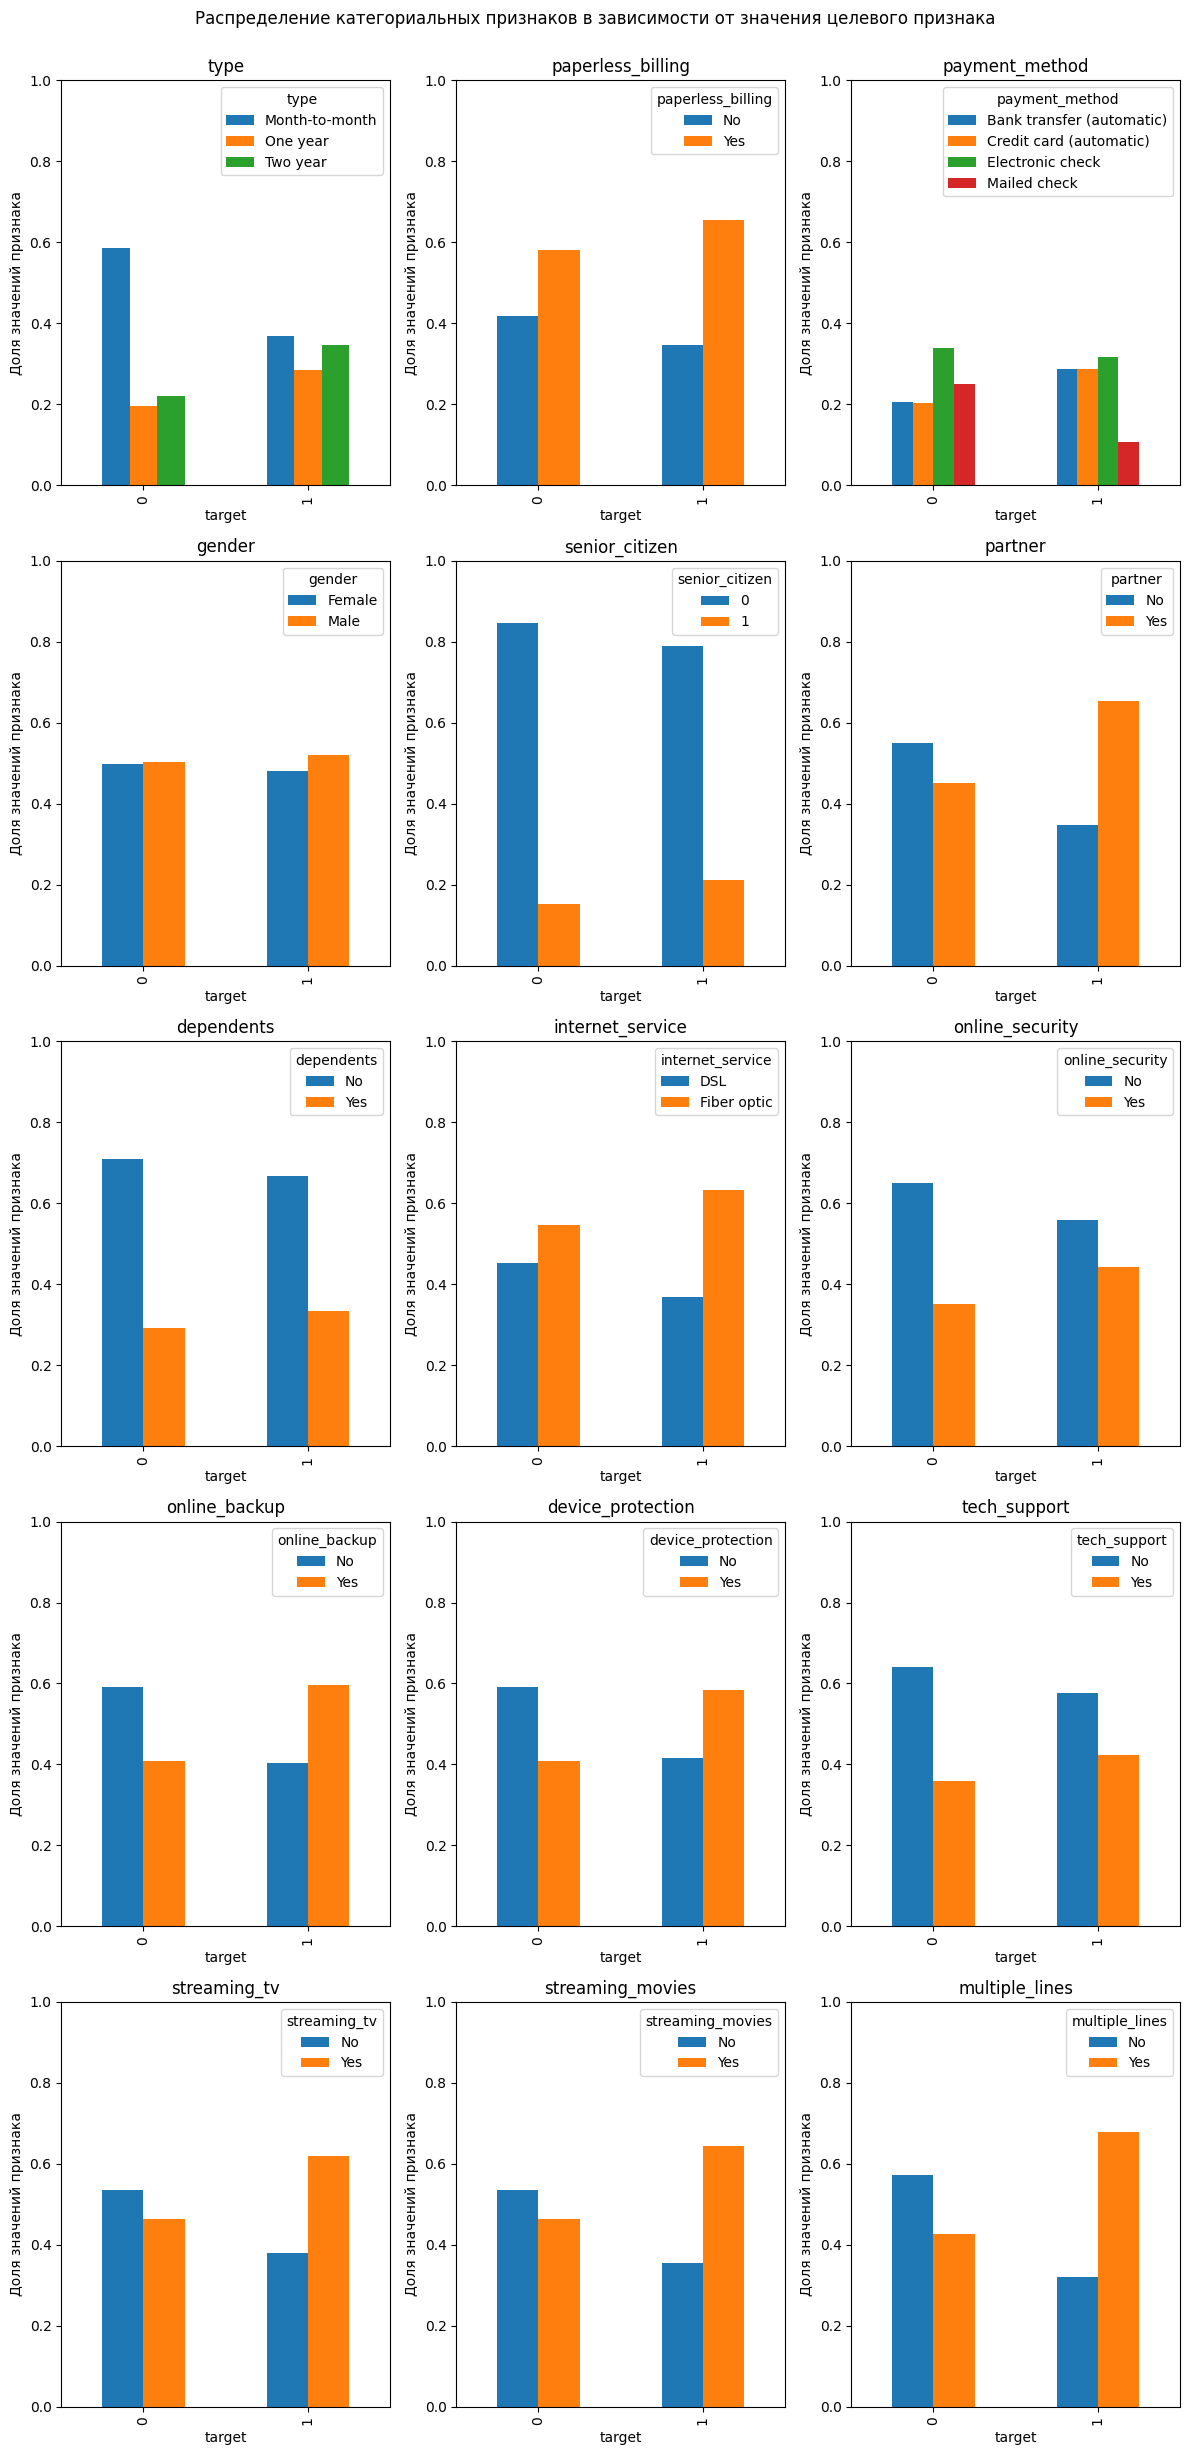

In [24]:
fig, ax = plt.subplots(nrows=5, ncols=3,figsize = (12,25))
plt.suptitle('Распределение категориальных признаков в зависимости от значения целевого признака')
for i, col in enumerate(category_features):
    ct = pd.crosstab(data['target'], data[col], normalize='index').plot.bar(ax = ax[i//3, i%3], title = col)
    ax[i//3, i%3].set_ylim(0,1)
    ax[i//3, i%3].set_ylabel('Доля значений признака')
plt.tight_layout(rect=[0, 0, 1, 0.98])

Практически во всех признаках имеются различия в распределении в зависимости от целевого признака. Удалять какие-либо из них на основе этого сравнения нет оснований.

Выделим числовые признаки.

In [25]:
numeric_features = ['monthly_charges', 'total_charges', 'period']

Сравним гистограммы числовых признаки в зависимости от целевого признака.

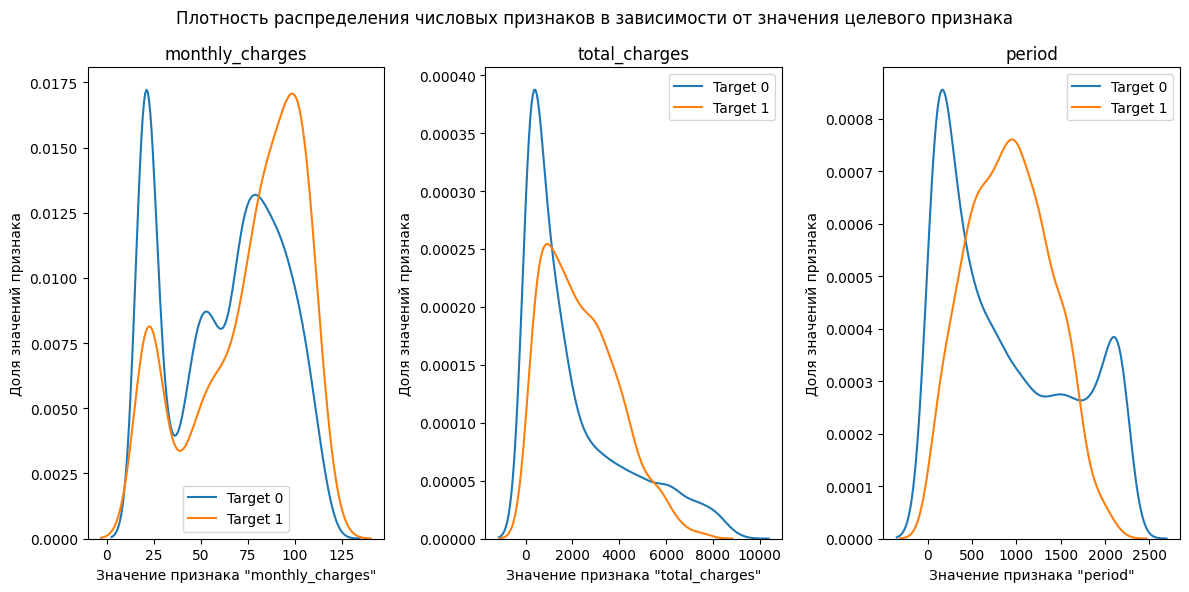

In [26]:
# Разделение данных на подгруппы по значениям столбца 'target'
grouped = data.groupby('target')

# Построение графиков для подгрупп
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
plt.suptitle('Плотность распределения числовых признаков в зависимости от значения целевого признака')

for i, col  in enumerate(numeric_features):
    for name, group in grouped[col]:
        sns.kdeplot(data = group, ax = ax[i])
    ax[i].set_title(col)
    ax[i].legend(['Target 0', 'Target 1'])
    ax[i].set_ylabel('Доля значений признака')
    ax[i].set_xlabel(f'Значение признака "{col}"')


plt.tight_layout()

Полученные графики демонстрируют существенные различия числовых признаков в зависимости от целевого признака.



Как отмечалось выше, в данных имеются пропуски, связанные с тем, что не все клиенты пользуются услугами Интернета или телефонии. Заполним пропуски в поле `multiple_lines` значениями "no_phone". Подобное заполнение пропусков в признаках, связанных с Интернетом, может привести к появлению мультиколлинеарности, поскольку многие записи получат одинаковые значения этих признаков. Чтобы этого избежать, заполним пропуски в признке `internet_service` знчением 'no_internet'. Это будет указывать на неиспользование клиентом услуг, связанных с Интернетом. Остальные признаки заполним значением 'No'. Такое значение в этих признаках уже имеется.

Поскольку заполняющее значение зависит только от категории услуг, которыми не пользуется клиет, заполнение пропусков можно провести до разделения на обучающую и тестовую выборки. К утечке данных это не приведет.

In [27]:
## Выделение признаков, связанных с использованием Интернета
internet_features = ['online_security', 'online_backup','device_protection', 
                     'tech_support', 'streaming_tv', 'streaming_movies']

## Заполнение пропусков, связанных с отсутствием Интернета
data['internet_service'] = data['internet_service'].fillna('no_internet')
data[internet_features] = data[internet_features].fillna('No')

## Заполнение пропусков, связанных с отсутствием телефона
data['multiple_lines'] = data['multiple_lines'].fillna('no_phone')

Проверим корректность заполнения.

In [28]:
data.isna().sum()

type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
target               0
period               0
dtype: int64

In [29]:
print(f'Число записей {len(data)}')

Число записей 7032


Заполнение пропусков проведено корректно. 

Посмотрим на корреляцию признаков. Используем библиотеку Phik.

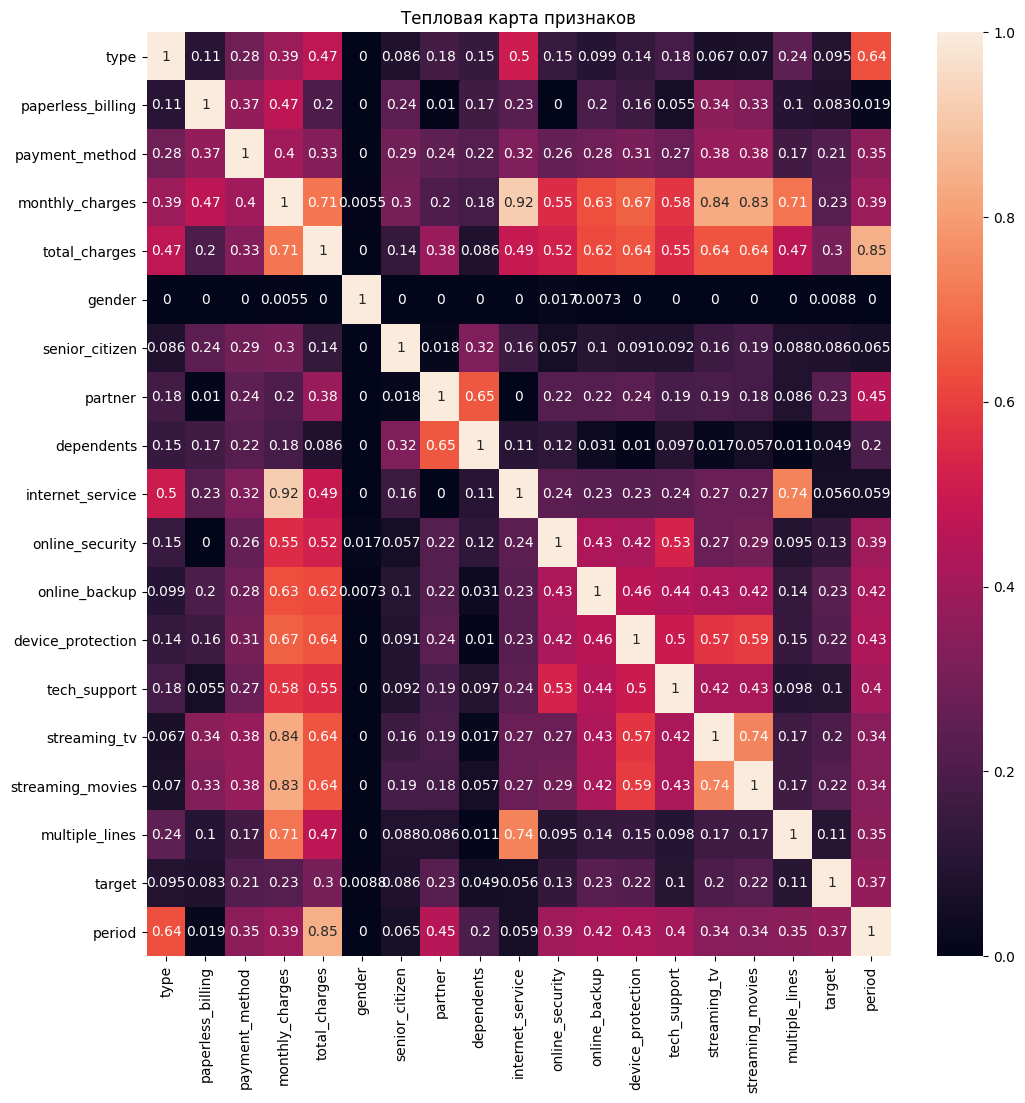

In [30]:
plt.figure(figsize=(12, 12))
sns.heatmap(data.phik_matrix(interval_cols = numeric_features), annot=True)
plt.title('Тепловая карта признаков');

После заполнения пропусков появилась сильная зависимость между признаками 'monthly_charge' и 'internet_service'. Удалим второй признак. Минимальное влияние на целевой признак, оказывает признак `gender`. Его тоже удалим.  Сильная зависимость целевого признака от какого-либо одного признака не наблюдается.

In [31]:
# выбор столбцов для удаления
columns_to_drop = ['gender', 'internet_service']
data = data.drop(columns = columns_to_drop) # удаление столбцов

# обновление списка категориальных признаков
category_features = list(filter(lambda x: x != 'gender' and 
                                x != 'internet_service', category_features))



Проверим соотношение классов.

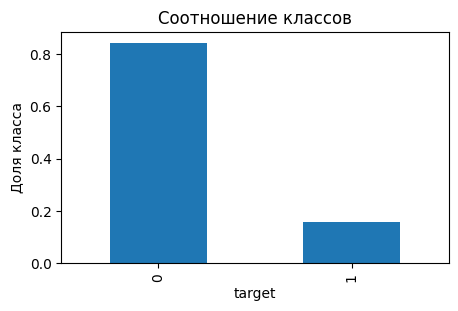

In [32]:
(data.groupby('target').size()/data['target'].count()).plot.bar(title = 'Соотношение классов', figsize = (5,3))
plt.ylabel('Доля класса');

Наблюдается дисбаланс классов, однако он не влияет на метрику ROC-AUC, используемую в данном проекте.

Выделим целевой признак и разделим данные на обучающую и тестовую выборки.

In [33]:
# Разделение на признаки и целевую переменную
X = data.drop('target', axis=1)
y = data['target']

In [34]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

Провеорим корректность разбиения.

In [35]:
print("Размерности датасетов:")
print(*list(map(lambda x: x.shape, [X_train, X_test, y_train, y_test])))

Размерности датасетов:
(5274, 16) (1758, 16) (5274,) (1758,)


Разбиение проведено корректно.

### Выводы

1. В процессе анализа признаков был создан новый признак `period` - длительность пользования услугами.
2. Для предотвращения утечки данных были удалены абсолютные даты.
3. Мультиколлинеарность признаков устранена.
4. Сильная зависимость целевого признака от какого-либо одного признака не наблюдается.
5. Присутствует дисбаланс классов, однако используемая метрика к нему нечувствительна.

## Создание моделей
### Catboost

In [36]:
# Создаем экземпляр классификатора
catboost_model = CatBoostClassifier(cat_features=category_features, random_state=RANDOM_STATE, verbose=0)

# Задаем параметры для поиска
param_grid_cbc = {'depth': [5, 6], 'learning_rate':[0.1, 0.3], 
                  'iterations' : [300, 500], 'loss_function': ['Logloss', 'CrossEntropy']}

# Создаем объект GridSearchCV
grid_search_cbc = GridSearchCV(estimator=catboost_model, param_grid=param_grid_cbc, scoring='roc_auc', cv=3, verbose=0)

# Запускаем поиск по сетке
grid_search_cbc.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001A0C65A2130>,
             param_grid={'depth': [5, 6], 'iterations': [300, 500],
                         'learning_rate': [0.1, 0.3],
                         'loss_function': ['Logloss', 'CrossEntropy']},
             scoring='roc_auc')

In [37]:
# Выводим лучшие параметры и значение ROC-AUC
print("Лучшие параметры:", grid_search_cbc.best_params_)
print("ROC-AUC на кросс-валидации:", grid_search_cbc.best_score_)

Лучшие параметры: {'depth': 5, 'iterations': 500, 'learning_rate': 0.1, 'loss_function': 'Logloss'}
ROC-AUC на кросс-валидации: 0.8915541544093585


Метрика на кросс-валидации удовлетворяет требованиям. Сохраним модель.

In [38]:
# Сохраняем модель
model_cbc = grid_search_cbc.best_estimator_

### Random Forest

In [39]:
# Создаем ColumnTransformer для применения разных преобразований к числовым и категориальным признакам
preprocessor_rf = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),  # Числовые признаки оставляем без изменений
        ('cat', OrdinalEncoder(), category_features)  # Применяем Ordinal Encoder к категориальным признакам
    ])


In [40]:
# Создаем Pipeline
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor_rf),
    ('rf', RandomForestClassifier(random_state=RANDOM_STATE))
])

In [41]:
# Задаем параметры для поиска
param_grid_rf = {
    'rf__n_estimators': [50, 200, 400],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [ 5, 10, 20],
    'rf__min_samples_leaf': [1, 2], 
    'rf__criterion': ['gini', 'entropy'], 
    'rf__class_weight': ['balanced', None]
}

In [42]:
# Создаем объект GridSearchCV
grid_search_rf = GridSearchCV(estimator=pipeline_rf, param_grid=param_grid_rf, scoring='roc_auc', cv=3, verbose=0)

grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         'passthrough',
                                                                         ['monthly_charges',
                                                                          'total_charges',
                                                                          'period']),
                                                                        ('cat',
                                                                         OrdinalEncoder(),
                                                                         ['type',
                                                                          'paperless_billing',
                                                                          'payment_method',
                                                                          'senior_citizen',
                                                                          'partner',
                                                                          'dependents',
                                                                          'online_security',
                                                                          'online_backup',
                                                                          'device_protection',
                                                                          'tech_support',
                                                                          'streaming_tv',
                                                                          'streaming_movies',
                                                                          'multiple_lines'])])),
                                       ('rf',
                                        RandomForestClassifier(random_state=170723))]),
             param_grid={'rf__class_weight': ['balanced', None],
                         'rf__criterion': ['gini', 'entropy'],
                         'rf__max_depth': [None, 10, 20],
                         'rf__min_samples_leaf': [1, 2],
                         'rf__min_samples_split': [5, 10, 20],
                         'rf__n_estimators': [50, 200, 400]},
             scoring='roc_auc')

In [43]:
print(f'Лучшее значение ROC-AUC на кросс-валидации {grid_search_rf.best_score_}')

Лучшее значение ROC-AUC на кросс-валидации 0.8294226554213577


Параметры лучшей модели:

In [44]:
grid_search_rf.best_params_

{'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': 10,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 20,
 'rf__n_estimators': 400}

### Логистическая регрессия

In [45]:
# Создаем ColumnTransformer для применения разных преобразований к числовым и категориальным признакам
preprocessor_lr = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # Числовые признаки стандартизируем
        ('cat', OneHotEncoder(drop='first'), category_features)  # Применяем Ordinal Encoder к категориальным признакам
    ])


In [46]:
# Создаем Pipeline
pipeline_lr = Pipeline([
    ('preprocessor', preprocessor_lr),
    ('lr', LogisticRegression(random_state=RANDOM_STATE))
])

In [47]:
pipeline_lr

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['monthly_charges',
                                                   'total_charges', 'period']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['type', 'paperless_billing',
                                                   'payment_method',
                                                   'senior_citizen', 'partner',
                                                   'dependents',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
                                                   'tech_support',
                                                   'streaming_tv',
                                                   'streaming_movies',
                                                   'multiple_lines'])])),
                ('lr', LogisticRegression(random_state=170723))])

In [48]:
# Задаем параметры для поиска
param_grid_lr = {
    'lr__penalty' : ['l1', 'l2', 'elasticnet'],
    'lr__class_weight' : ['balanced', None],
    'lr__solver' : ['lbfgs', 'newton-cholesky'],
}

In [49]:
warnings.filterwarnings('ignore')
# Создаем объект GridSearchCV
grid_search_lr = GridSearchCV(estimator=pipeline_lr, param_grid=param_grid_lr, scoring='roc_auc', cv=3, verbose=0)

grid_search_lr.fit(X_train, y_train)

warnings.filterwarnings('default')

In [50]:
print(f'Лучшее значение ROC-AUC на кросс-валидации {grid_search_lr.best_score_}')

Лучшее значение ROC-AUC на кросс-валидации 0.7604251599368492


Параметры лучшей модели:

In [51]:
grid_search_lr.best_params_

{'lr__class_weight': 'balanced', 'lr__penalty': 'l2', 'lr__solver': 'lbfgs'}

### Выбор и анализ лучшей модели

Наилучшую метрику на кросс-валидации показала модель CatBoost. Рассчитаем для нее значение метрики ROC-AUC на тестовой выборке.

In [52]:
prob_cbc_test = model_cbc.predict_proba(X_test)

ra_cbc_test = roc_auc_score(y_test, prob_cbc_test[:,1])
print(f'ROC-AUC на тестовой выборке {ra_cbc_test}')

ROC-AUC на тестовой выборке 0.9233200514926745


Рассмотрим важность признаков модели.

In [53]:
pd.DataFrame({'Признак' : model_cbc.feature_names_, 'Важность' : model_cbc.feature_importances_}).sort_values(
                by = 'Важность', ascending=False).reset_index(drop=True)

,Признак,Важность
0,period,53.555248
1,total_charges,9.763350
2,monthly_charges,9.056724
3,type,8.512172
4,payment_method,4.393178
5,multiple_lines,3.930892
6,partner,3.195657
7,dependents,1.412065
8,online_backup,1.019667
9,paperless_billing,0.817004


Составим матрицу ошибок.

In [54]:
# Получим предсказания модели
predictions_cbc = model_cbc.predict(X_test)

# Составляем матрицу ошибок
conf_matrix = pd.crosstab (y_test, predictions_cbc)
conf_matrix.index.rename('Actual', inplace= True)
conf_matrix.columns.rename('Predictions', inplace= True)

conf_matrix

Predictions,0,1
Actual,,
0,1465,18
1,120,155


Рассчитаем TPR и FPR

In [55]:
tpr_test = conf_matrix.loc[1,1] / (conf_matrix.loc[1,1] + conf_matrix.loc[1,0])
fpr_test = conf_matrix.loc[0,1] / (conf_matrix.loc[0,1] + conf_matrix.loc[0,0])
print(f'TPR = {tpr_test}, FPR = {fpr_test}')

TPR = 0.5636363636363636, FPR = 0.012137559002022926


Построим графики ROC-кривой и зависимости TPR и FPR от выбора порога.

In [56]:
# получаем FPR, TPR и пороговые значения
fpr, tpr, thresholds_roc = roc_curve(y_test, prob_cbc_test[:,1])
# получаем precision, recall и пороговые значения
precision, recall, thresholds_pr = precision_recall_curve(y_test, prob_cbc_test[:,1])

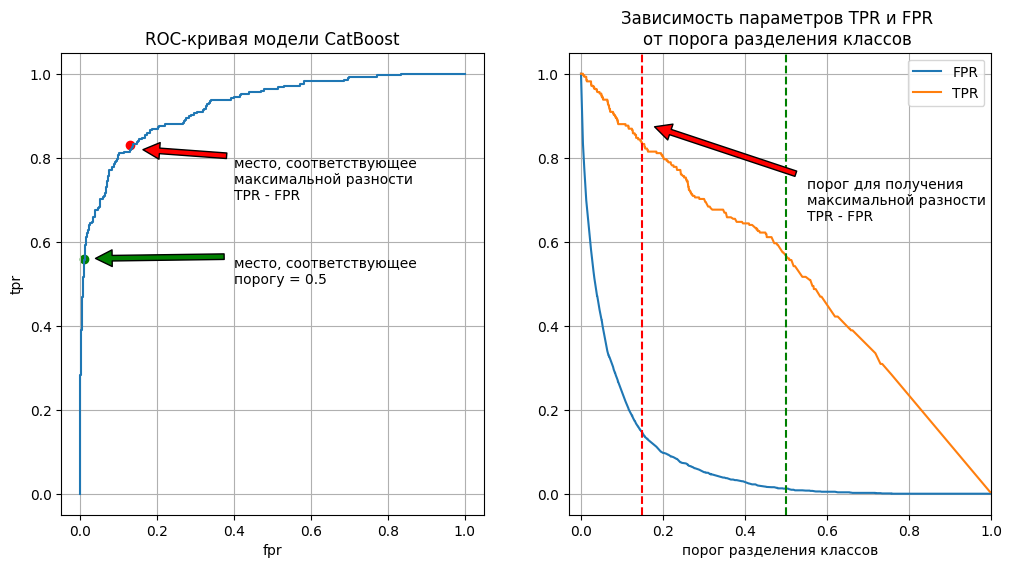

In [57]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize = (12,6))

# построение ROC-кривой
ax[0].plot(fpr, tpr)
ax[0].scatter(0.13, 0.83, color = 'r')
ax[0].scatter(0.01, 0.56, color = 'g')
ax[0].set_title('ROC-кривая модели CatBoost')
ax[0].annotate('место, соответствующее\nмаксимальной разности\nTPR - FPR', 
             xy=(0.15, 0.82), xytext=(0.4, 0.7), arrowprops=dict(facecolor='red', shrink=0.05))
ax[0].annotate('место, соответствующее\nпорогу = 0.5', 
             xy=(0.02, 0.56), xytext=(0.4, 0.5), arrowprops=dict(facecolor='g', shrink=0.05))
ax[0].grid()
ax[0].set_xlabel('fpr')
ax[0].set_ylabel('tpr')

# построение графика зависимости TPR и FPR от порога
ax[1].plot(thresholds_roc, fpr, label = 'FPR')
ax[1].plot(thresholds_roc, tpr, label = 'TPR')
ax[1].axvline(0.15, c = 'r', ls = '--')
ax[1].axvline(0.5, c = 'g', ls = '--')
ax[1].set_title('Зависимость параметров TPR и FPR \nот порога разделения классов ')
ax[1].annotate('порог для получения\nмаксимальной разности\nTPR - FPR', 
             xy=(0.16, 0.88), xytext=(0.55, 0.65), arrowprops=dict(facecolor='red', shrink=0.05))
ax[1].grid()
ax[1].set_xlim(-0.03, 1)
ax[1].set_xlabel('порог разделения классов')
ax[1].legend();


Для оптимального выбора порога необходимо провести дополнительный анализ, где нужно учесть соотношение классов и стоимость ошибок прогнозирования.

## Отчет по решению

В результате выполнения проекта была создана модель прогнозирования оттока клиентов. Созданная модель выявляет клиентов, склонных к отказу от услуг компании, и имеет метрику ROC-AUC, превосходящую минимальные требования.

Модель использует большинство предоставленных оператором признаков за исключением следующих:

- Признаки `'begin_date', 'end_date'` были удалены для избежания утечки данных.
- Признак `'gender'` был удален из-за низкой корреляции с целевым признаком. 
- Признак `'internet_service'` был удален из-за мультиколлинеарности.


Вместо признаков, содержащих конкретные даты, был создан признак `'period'` - длительность пользования услугами.

Пропуски в признаке `'multiple_lines'` были заполнены новым значением. Пропуски в признаках, связанных с использованием Интернета, были заполнены уже существующим значением 'No'.

В процессе исследования были созданы три модели:
- модель CatBoost
- модель Random Forest
- модель логистической регрессии

Из них только модель CatBoost обеспечила требуемые значения метрики. Именно она будет предложена заказчику.

**Гиперпараметаы модели CatBoost**

| Гиперпараметр | Значение|
|:----:|:------:|
|iterations|500|
|learning_rate	|0.1|
|depth|5|
|loss_function|Logloss|
|random_state|170723|


На тестовой выборке модель показала метрику **ROC-AUC = 0.923**.